# Lab 1 Extra: Uncertainty Propagation
### Gaussian Process Summer School 2020

This lab is an extension on the work introduced in Lab 1 of the summer school. It is more advanced, and you should make sure you've completed Lab 1 before attempting. It is designed to demonstrate the advantage of using models when we have only a small number of observations of a latent function $f$.

Extra labs are for you to explore in your own time, giving details of other uses of Gaussian processes not covered in the summer school. Answers for extra labs will be made available _after_ the summer school.

In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

## The Branin Function

For this lab we will focus on the [Branin-Hoo function](https://www.sfu.ca/~ssurjano/branin.html) as our latent function. The Branin-Hoo function in two-dimensions is typically used as an _artificial landscape_, i.e. a test function for optimisation. We will the most common version of the function

$$
    f(\mathbf{x}) = a(x_2 - bx_1^2 + cx_1 - r)^2 + s(1-t)\cos(x_1) + s,
$$

with paremeters defined:
$$
    a = 1, \quad b = \frac{5.1}{4\pi^2}, \quad c=\frac{5}{\pi}, \quad r = 6, \quad s = 10, \quad t=\frac{1}{8\pi}
$$

We will define the function over the space $\Omega = [-5, 10] \times [0, 15]$.

We can create some samples of the function, $N=20$, sampled uniformly over the space:

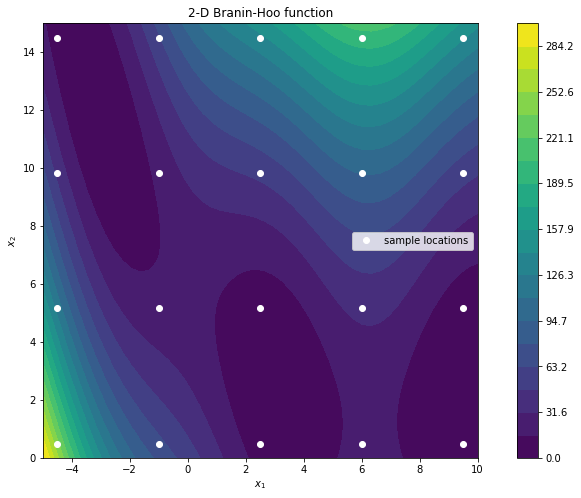

In [2]:
def f(Xi, Xj): # Define Branin function
    a, b, c, r, s, t = 1., 5.1/(4*np.pi**2), 5/np.pi, 6., 10., 1./(8*np.pi)
    f_ = lambda x1,x2: \
        a*(x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*np.cos(x1) + s
    return np.reshape([f_(x1, x2) for (x1, x2) in zip(Xi[:], Xj[:])], Xi.shape)
    
# Define the function space
Xi, Xj = np.meshgrid(np.linspace(-5., 10., 50), np.linspace(0., 15., 50))

# We will also define some samples
Xsi, Xsj = np.meshgrid(np.linspace(-4.5, 9.5, 5), np.linspace(0.5, 14.5, 4))
X = np.vstack((Xsi.ravel(), Xsj.ravel())).T
# Our observations
y = f(Xsi, Xsj).ravel()[:, None]

# Plot the Branin function
plt.figure(figsize=(14, 8))

plt.contourf(Xi, Xj, f(Xi, Xj), levels=np.linspace(0, 300, 20))
plt.plot(X[:,0], X[:,1], 'wo')

plt.xlabel('$x_1$'), plt.ylabel('$x_2$'), plt.title("2-D Branin-Hoo function")
plt.legend(labels=["sample locations"])
plt.axis('square'), plt.colorbar();

### Exercise 1

Using `GPy`, fit a GP that is the product of two kernels over the two different inputs. Compare this fit to that of a GP with an isotropic RBF kernel.

GP_regression.,value,constraints,priors
mul.rbf.variance,15308.189387215683,+ve,
mul.rbf.lengthscale,23.192541106085837,+ve,
mul.rbf_1.variance,15308.190782336731,+ve,
mul.rbf_1.lengthscale,146.98147501349206,+ve,
Gaussian_noise.variance,5.562684646268137e-309,+ve,


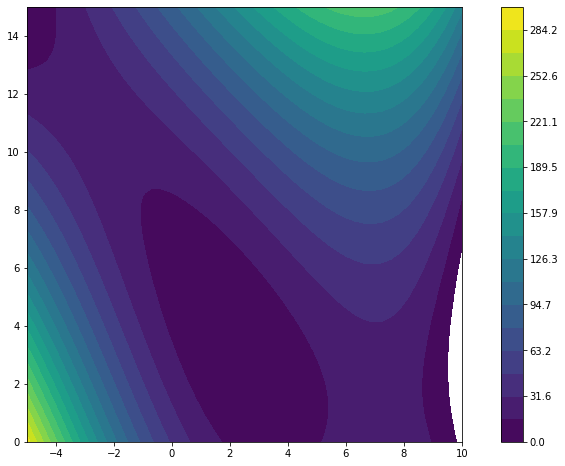

In [3]:
m1 = GPy.models.GPRegression(
    X, y,
    kernel = GPy.kern.RBF(1, active_dims=[0]) * GPy.kern.RBF(1, active_dims=[1])
)

m1.optimize()

Xnew = np.vstack((Xi.ravel(), Xj.ravel())).T

mu, Sig = m1.predict(Xnew, include_likelihood=False)


plt.figure(figsize=(14, 8))

plt.contourf(Xi, Xj, np.reshape(mu,(50,50)), levels=np.linspace(0, 300, 20))
plt.axis('square'), plt.colorbar();

display(m1)

GP_regression.,value,constraints,priors
rbf.variance,672398.7240957518,+ve,
rbf.lengthscale,12.427228702547053,+ve,
Gaussian_noise.variance,5.562684646268137e-309,+ve,


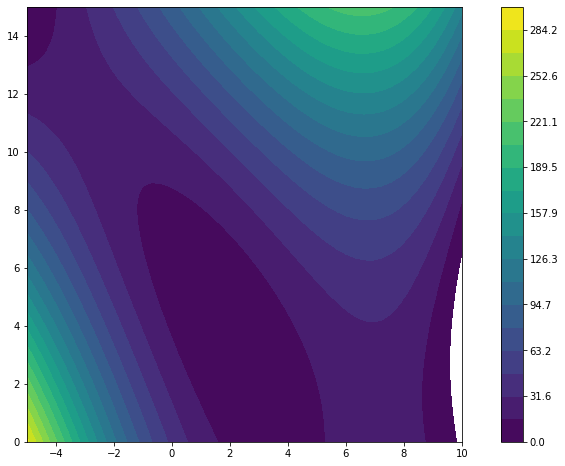

In [4]:
m2 = GPy.models.GPRegression(
    X, y,
    kernel = GPy.kern.RBF(2, ARD=False)
)

m2.optimize()

Xnew = np.vstack((Xi.ravel(), Xj.ravel())).T

mu, Sig = m2.predict(Xnew, include_likelihood=False)


plt.figure(figsize=(14, 8))

plt.contourf(Xi, Xj, np.reshape(mu,(50,50)), levels=np.linspace(0, 300, 20))
plt.axis('square'), plt.colorbar();

display(m2)

## Analysis of Uncertainty

Let X be a random variable defined over the real numbers, $\mathbb{R}$, and let $f : \mathbb{R} \to \mathbb{R}$ be a mapping between real numbers. Uncertainty analysis is the study of the distribution of the random variable $f(X)$.

We will assume in this example that $f$ is the Branin-Hoo function defined above and that $X$ is a random variable with *uniform* distribution over the input space of $f$.

### Computing $\mathbb{E}[f(X)]$

The expectation of $f(X)$ is given by $\int_Xf(x)\mathrm{d}x$. The basic approach to approximating the integral is to compute the mean of our 20 observations and compare it to the true value, $\mathbb{E}[f(X)] = 54.31$:

In [5]:
np.mean(y) # Mean of our samples

67.43511010158977

However, we can do better by instead using Monte Carlo sampling of a Gaussian process. We define $10^5$ Monte Carlo samples over our function space:

In [6]:
# Define the function space
Ximc, Xjmc = np.meshgrid(np.linspace(-5., 10., 100), np.linspace(0., 15., 100))
Xmc = np.vstack((Ximc.ravel(), Xjmc.ravel())).T

### Exercise 2
(a) Use your GP fit from the previous exercise to calculate the mean of the samples evaluated over your model of the Branin function. Discuss how it compares to the sample mean and true expectation of the Branin function.

In [7]:
mu, Cov = m1.predict(Xmc, include_likelihood=True)
np.mean(mu)

57.91347373791677

(b) Can you utilise the prediction variance to create a confidence interval for the prediction of the mean? Does the true value lie within this bound?

In [8]:
lb, ub = mu - 1.96*np.sqrt(np.diag(Cov)), mu + 1.96*np.sqrt(np.diag(Cov))

print(np.mean(lb))
print(np.mean(ub))

56.97838025272408
58.848567223109455


### Computing $P(f(X) > 200)$

In many cases, we might be interested in looking at the probability that $f(x)$ will take the value above a given threshold. For example, in the case that $f$ is the response of some physical model that represents the maximum constraint in a structure, it may be necessary to ascertain the probability that the constraint exceeds some maximum value.

### Exercise 3
(a) Use the original 20 observations to calculate an approximate estimate of the probabilty that $f(X) > 200$.

In [9]:
np.sum(y > 200) / len(y)

0.05

(b) Compute the probability that the best predictor of your GP is greater than the threshold ($200$), with confidence intervals. How does your estimation compare with the true value: $P(f(X) > 200) = 1.23\times 10^{−2}$.

In [10]:
print(np.sum(lb > 200) / len(mu))
print(np.sum(mu > 200) / len(mu))
print(np.sum(ub > 200) / len(mu))

0.016
0.0167
0.0173


(c) Can you design and implement a procedure that updates the GP model sequentially with new points in order to improve the estimation of $P(f(X) > 200)$?

> Review Bayesian optimisation notebook -- exercise left to the reader.

### Credit

This notebook was written by Wil Ward. It is adapted from notebooks by [Rich Wilkinson](https://rich-d-wilkinson.github.io/) and [Neil Lawrence](http://inverseprobability.com/).